In [2]:
import pandas as pd
import numpy as np
import os
import nexrad
import pvlib

In [9]:
NEXRAD_LOCATIONS = nexrad.get_lat_lon()

def load_data(root, station, year, cache=None):
    
    if cache is not None:
        return cache
    
    summary_folder = f'{root}/summary_folder'
    file = f'{summary_folder}/{station}-{year}.csv'
    
    if os.path.exists(file):
        df = pd.read_csv(file)
        df['date'] = pd.to_datetime(df['date'], utc=True)
        df = df.set_index('date')
        return df
    else:
        return None

def init_daily_data(station, year):
    # First and last days of year
    start = pd.Timestamp(year=year, month=1, day=1)
    end = pd.Timestamp(year=year+1, month=1, day=1) - pd.Timedelta('1 days')
    
    # location information
    lon = NEXRAD_LOCATIONS[station]['lon']
    lat = NEXRAD_LOCATIONS[station]['lat']
    loc = pvlib.location.Location(lat, lon)
        
    days = pd.date_range(start, end, freq='D', tz='UTC')
    daily_data = loc.get_sun_rise_set_transit(days)
    
    day_length = daily_data['sunset'] - daily_data['sunrise']
    day_length = np.mod(day_length / pd.Timedelta(1, 'h'), 24)
    night_length = 24 - day_length
    
    daily_data['day_length'] = day_length
    daily_data['night_length'] = night_length
    
    daily_data['day_reflectivity'] = 0
    daily_data['night_reflectivity'] = 0
    
    return daily_data
    

In [10]:
root = '../data'
df = load_data(root, "KBOX", 2016)
daily_data = init_daily_data("KBOX", 2016)
#display(df)
#display(daily_data)
df.index[-1]

Timestamp('2016-12-31 21:42:24+0000', tz='UTC')

In [8]:

def get_rows(df, start, end, last_df=None, next_df=None):
    '''
    Get rows from df with index value between start and end. 
    Also include rows from last_df and next_df if they are not None.

    Assumes data frames have same index and rows in last_df precede
    those of df, while rows of next_df succeed those of df.
    '''
    # Get rows from main data frame
    rows = df[start:end]

    # Add rows for edge cases
    if last_df is not None and start < last_df.index[-1]:
        rows = pd.concat([last_df[start:end], rows])
    if next_df is not None and end > next_df.index[0]:
        rows = pd.concat([rows, next_df[start:end]])

    return rows


def test_get_rows():
    station = 'KBOX'
    year = 2017
    
    last_df = load_data(root, station, year-1)
    df = load_data(root, station, year)
    next_df = load_data(root, station, year+1)
    
    # Get rows spanning last_df and df
    start = pd.Timestamp('2016-12-31 20:00:00Z')
    end = pd.Timestamp('2017-01-01 01:00:00Z')
    rows = get_rows(df, start, end, last_df=last_df, next_df=next_df)
    display(rows)
   
    # Get rows spanning df and next_df
    start = pd.Timestamp('2017-12-31 20:00:00Z')
    end = pd.Timestamp('2018-01-01 01:00:00Z')
    rows = get_rows(df, start, end, last_df=last_df, next_df=next_df)
    display(rows)
    
test_get_rows()   


,station,lat,lon,solar_elevation,total_reflectivity_bio,total_reflectivity_unfiltered,avg_u,avg_v,avg_speed,avg_track,total_percent_rain
date,,,,,,,,,,,
2016-12-31 20:12:00+00:00,KBOX,41.95583,-71.1375,9.7395,9.2307,9.8903,-1.5150,35.0527,35.7725,357.5251,0.0191
2016-12-31 20:41:14+00:00,KBOX,41.95583,-71.1375,5.6256,11.5546,13.1347,-0.8329,36.0919,36.3890,358.6779,0.0213
2016-12-31 21:10:27+00:00,KBOX,41.95583,-71.1375,1.2088,41.1848,43.5274,-11.5064,8.4764,15.1217,306.3779,0.0089
2016-12-31 21:42:24+00:00,KBOX,41.95583,-71.1375,-3.9124,4.2022,16.7031,17.0439,33.0287,37.6347,27.2953,0.0177
2017-01-01 00:03:44+00:00,KBOX,41.95583,-71.1375,-28.9065,1.3157,363.0450,18.5754,26.0691,32.6985,35.4716,0.0946
2017-01-01 00:08:40+00:00,KBOX,41.95583,-71.1375,-29.8189,2.0992,358.7535,18.4615,26.5712,32.9277,34.7913,0.0935
2017-01-01 00:13:37+00:00,KBOX,41.95583,-71.1375,-30.7354,1.2097,349.4275,16.7415,23.9348,29.9866,34.9714,0.1157
2017-01-01 00:18:33+00:00,KBOX,41.95583,-71.1375,-31.6499,1.0261,337.1150,19.3381,22.5942,30.4391,40.5599,0.1233
2017-01-01 00:23:29+00:00,KBOX,41.95583,-71.1375,-32.5651,1.2671,332.4051,19.5228,23.3248,31.0047,39.9293,0.1376


,station,lat,lon,solar_elevation,total_reflectivity_bio,total_reflectivity_unfiltered,avg_u,avg_v,avg_speed,avg_track,total_percent_rain
date,,,,,,,,,,,
2017-12-31 20:07:41+00:00,KBOX,41.95583,-71.1375,10.2868,9.9679,10.0194,2.5386,-35.4109,35.7812,175.8995,0.0030
2017-12-31 20:46:41+00:00,KBOX,41.95583,-71.1375,4.7917,6.3825,6.6765,22.6802,-28.1948,36.2573,141.1864,0.0076
2017-12-31 21:15:56+00:00,KBOX,41.95583,-71.1375,0.3179,7.2671,8.1550,-6.2530,40.2688,41.1191,351.1735,0.0076
2017-12-31 21:45:11+00:00,KBOX,41.95583,-71.1375,-4.4034,3.4075,3.4141,17.4033,-32.3995,36.8436,151.7576,0.0006
2018-01-01 00:03:36+00:00,KBOX,41.95583,-71.1375,-28.9144,1.6229,1.6233,-31.2703,-38.9601,50.0601,218.7514,0.0002
2018-01-01 00:13:22+00:00,KBOX,41.95583,-71.1375,-30.7217,2.1998,2.2045,12.6596,-28.1650,30.9200,155.7971,0.0028
2018-01-01 00:23:07+00:00,KBOX,41.95583,-71.1375,-32.5296,1.2828,1.2905,-3.0219,41.8759,42.0626,355.8725,0.0025
2018-01-01 00:32:52+00:00,KBOX,41.95583,-71.1375,-34.3401,1.7081,1.7103,-16.1481,25.8658,30.6789,328.0233,0.0014
2018-01-01 00:42:37+00:00,KBOX,41.95583,-71.1375,-36.1517,1.8554,1.8559,11.3512,-27.7421,30.2548,157.7472,0.0002


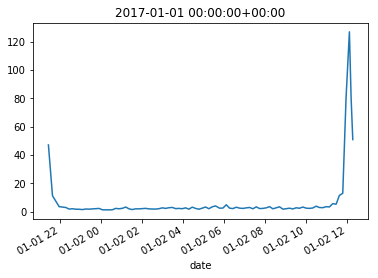

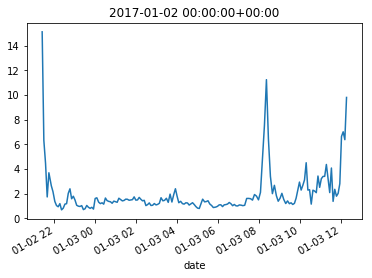

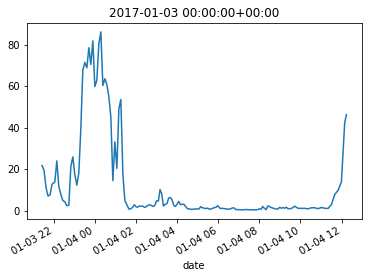

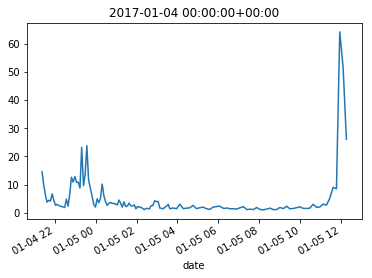

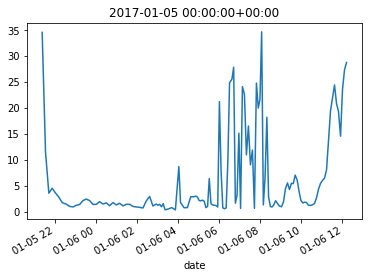

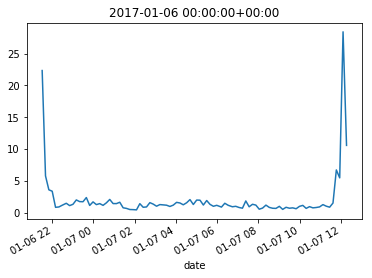

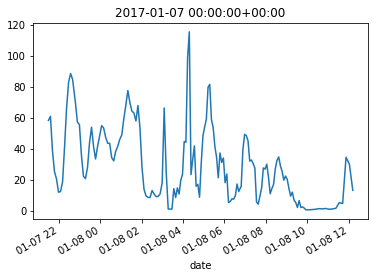

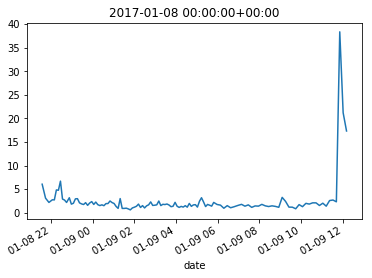

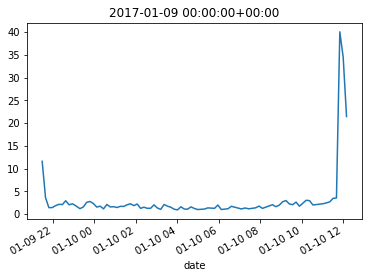

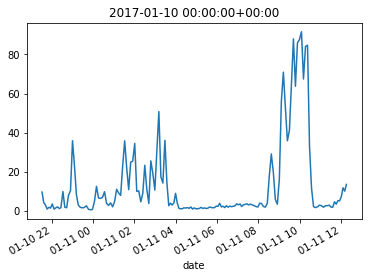

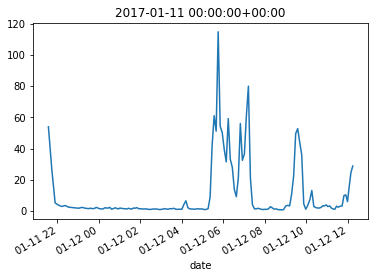

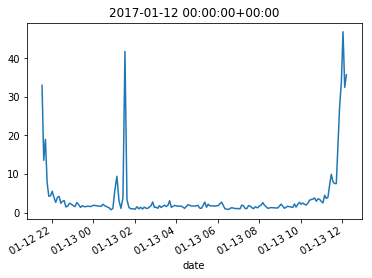

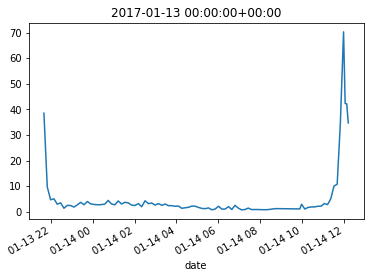

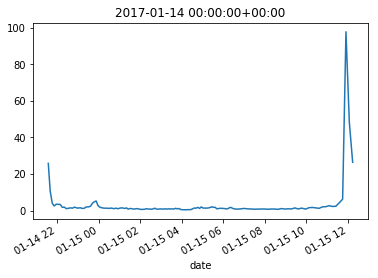

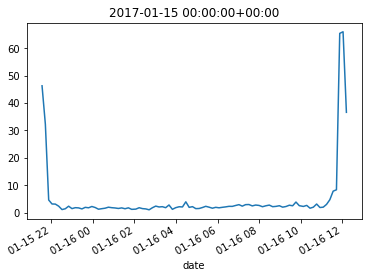

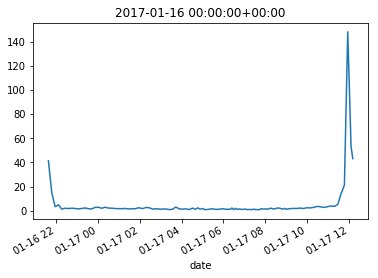

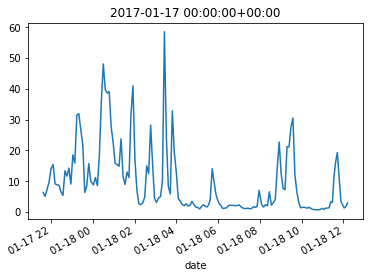

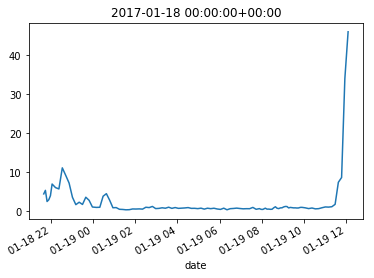

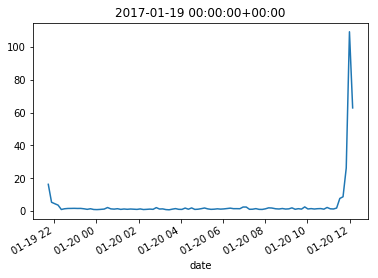

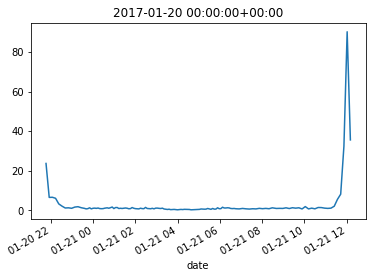

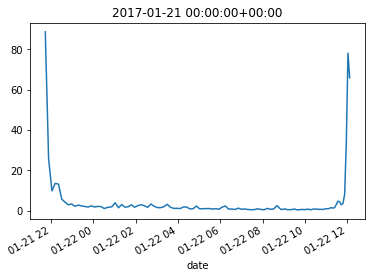

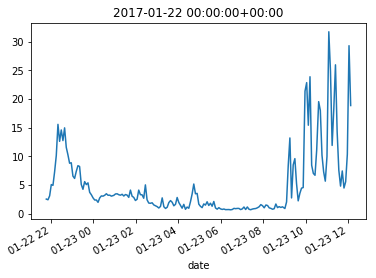

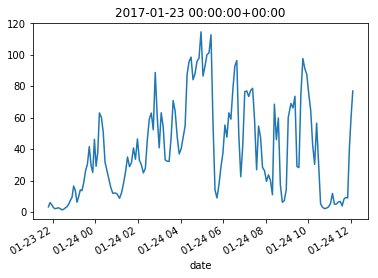

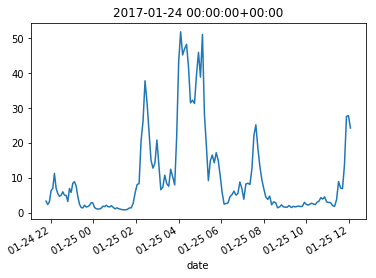

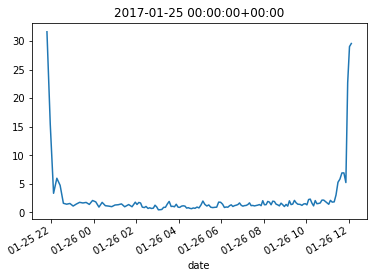

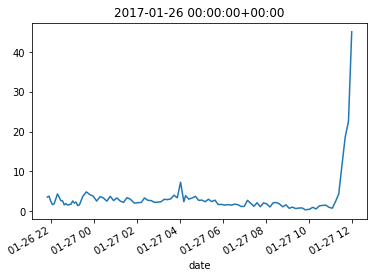

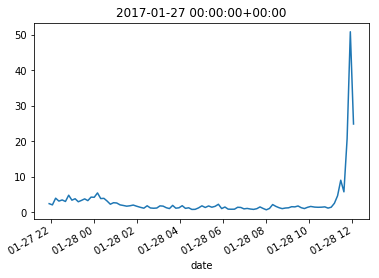

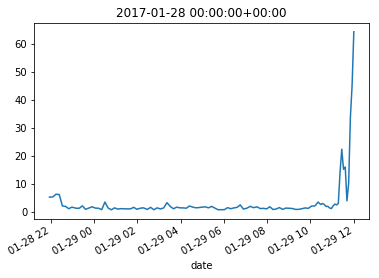

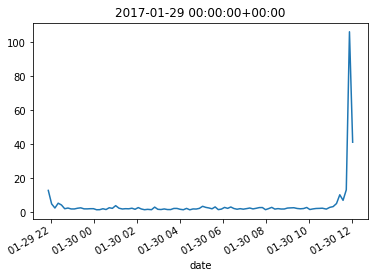

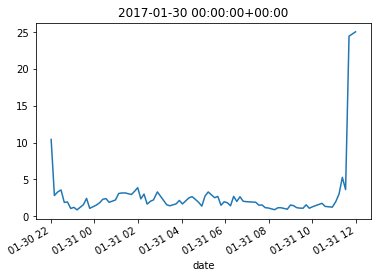

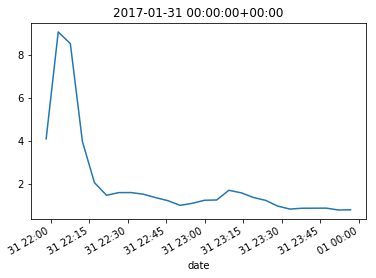

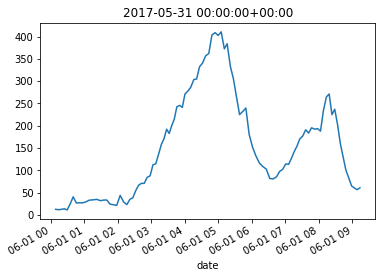

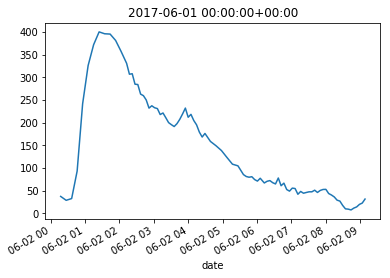

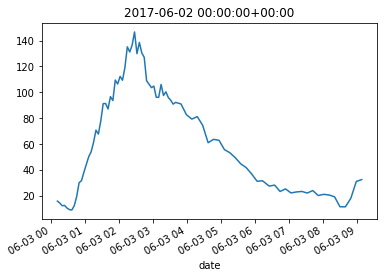

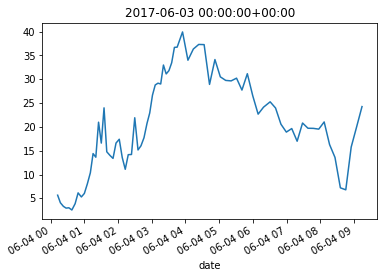

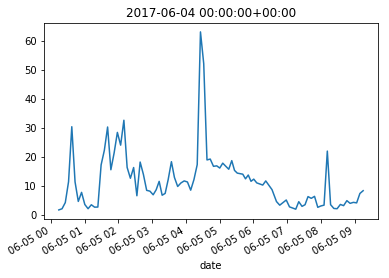

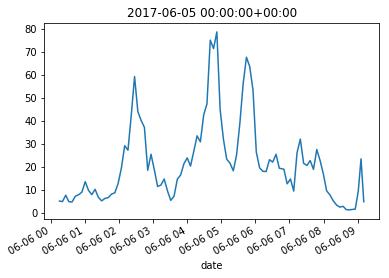

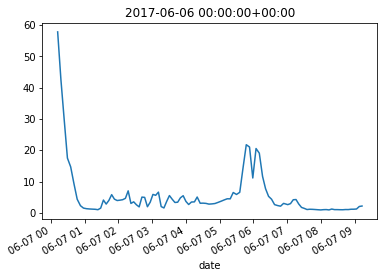

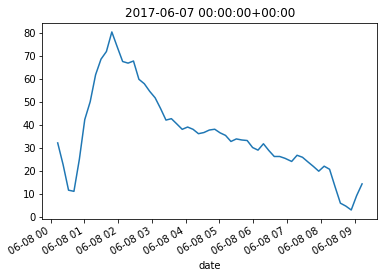

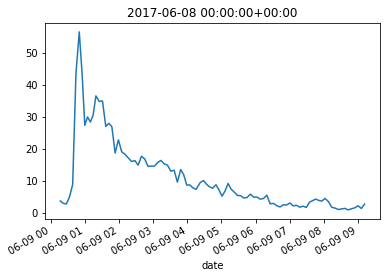

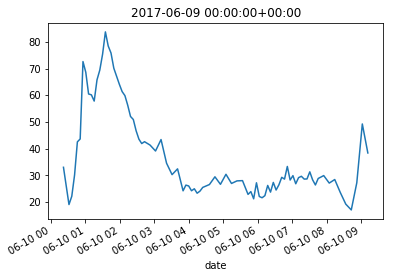

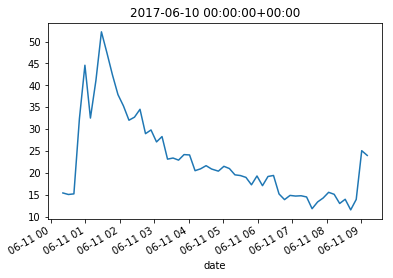

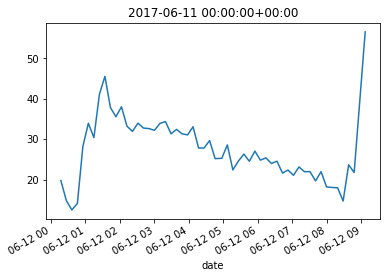

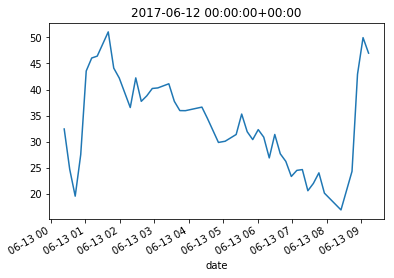

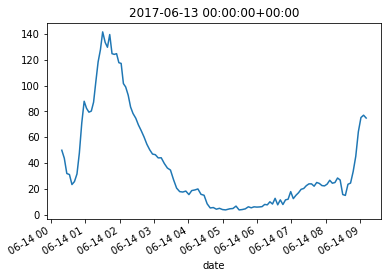

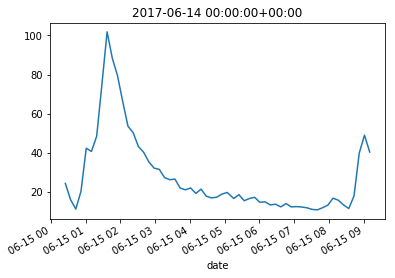

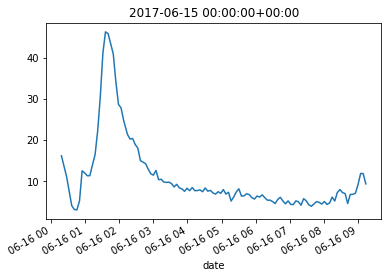

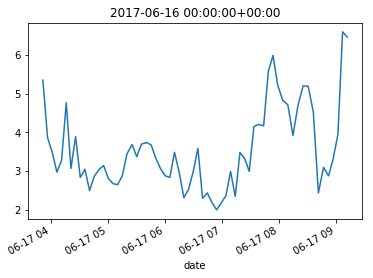

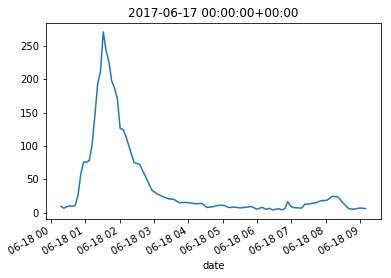

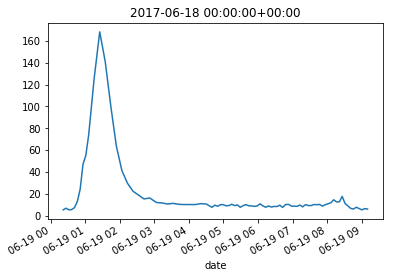

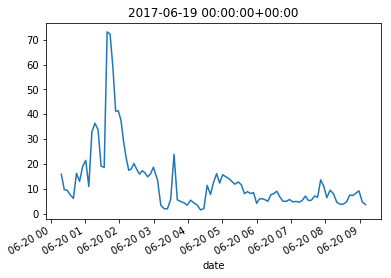

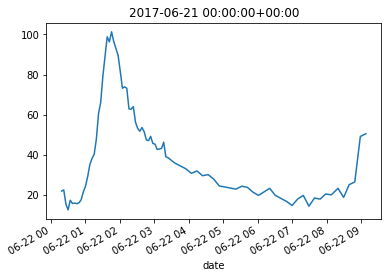

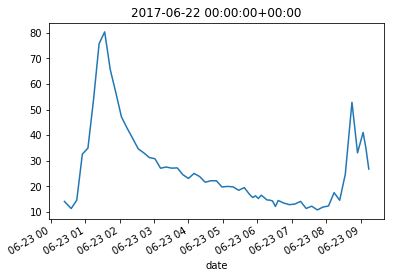

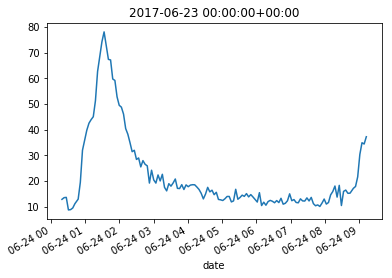

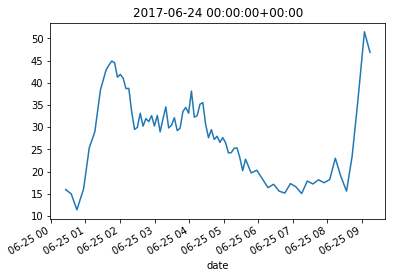

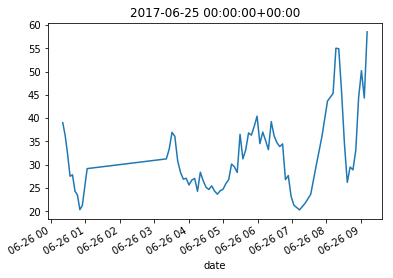

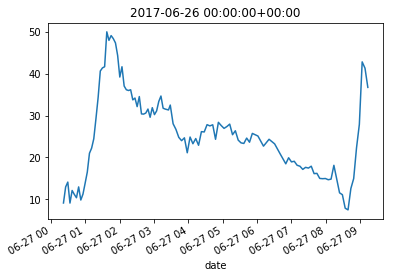

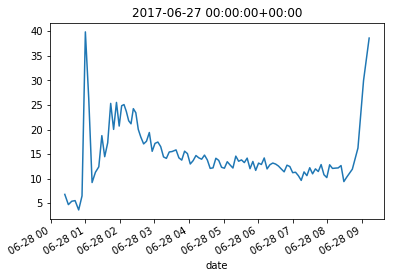

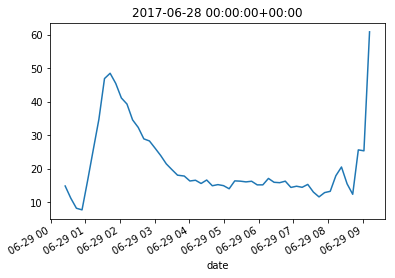

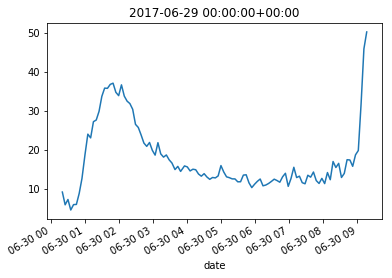

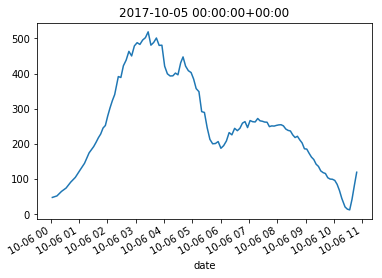

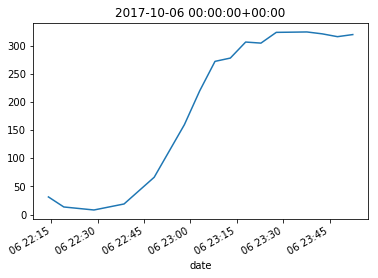

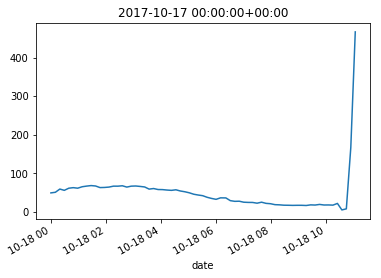

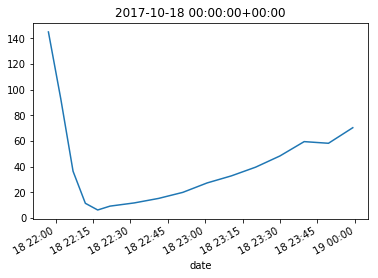

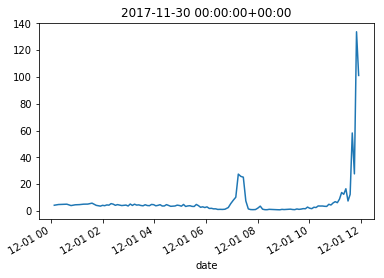

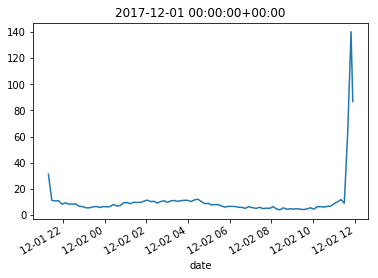

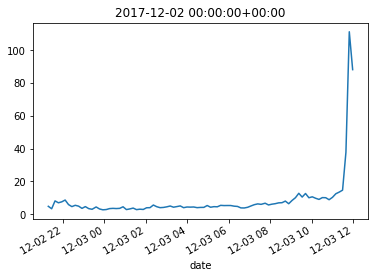

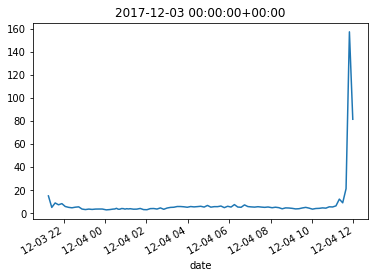

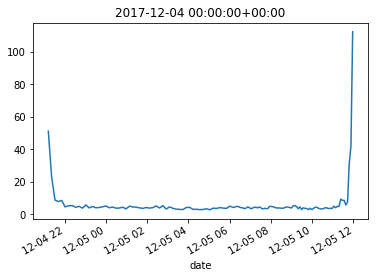

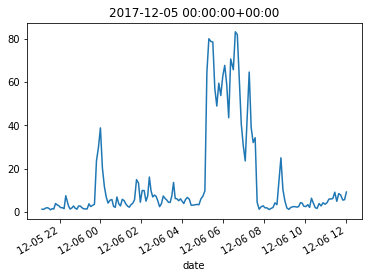

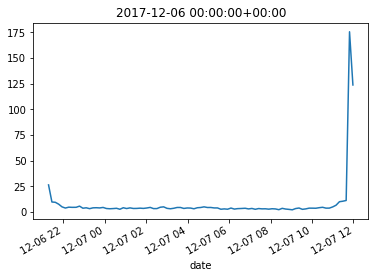

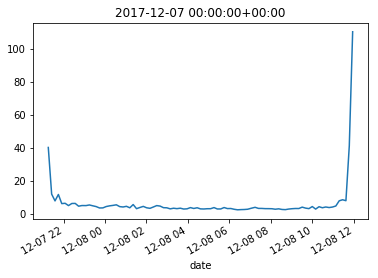

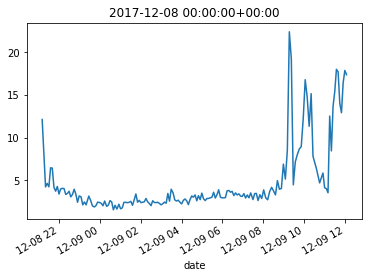

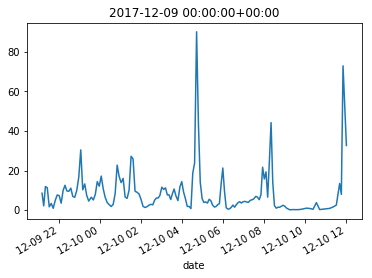

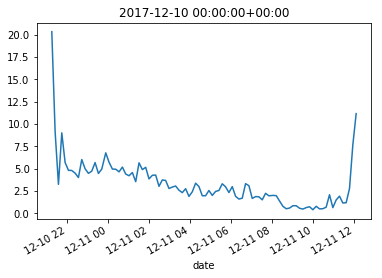

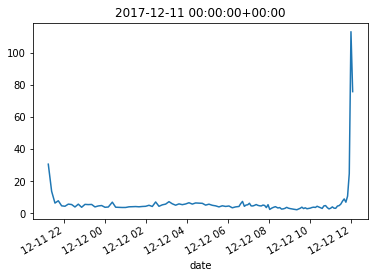

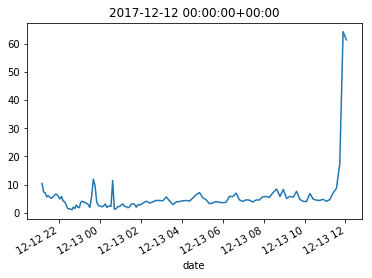

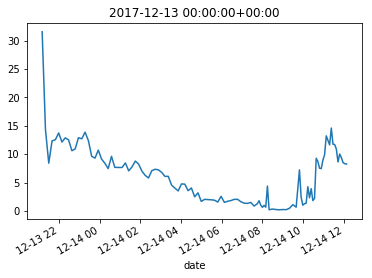

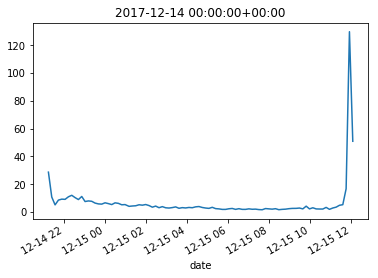

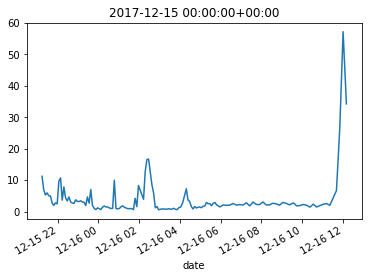

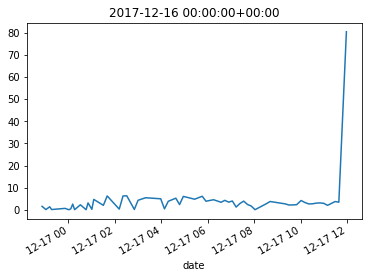

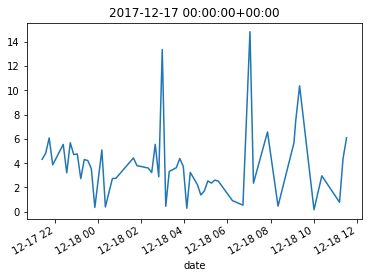

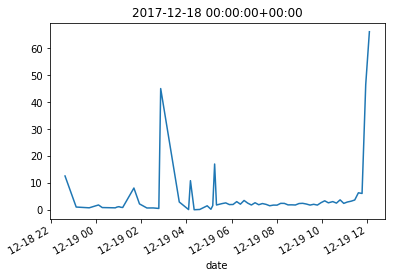

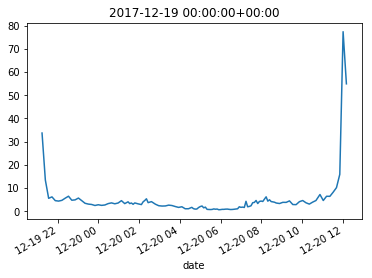

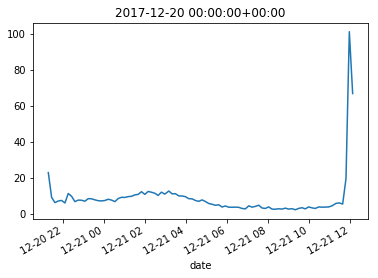

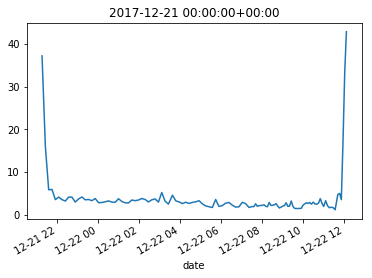

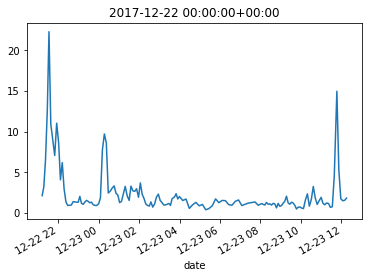

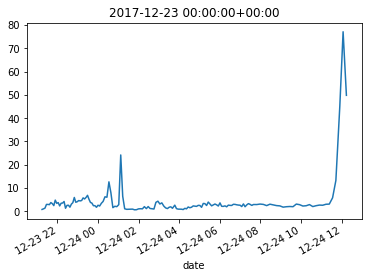

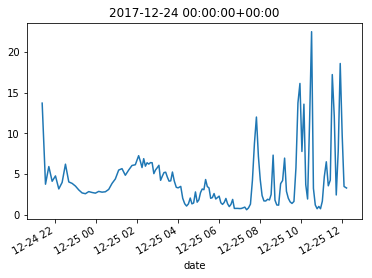

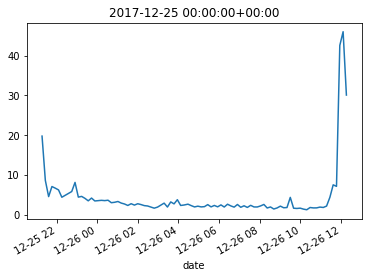

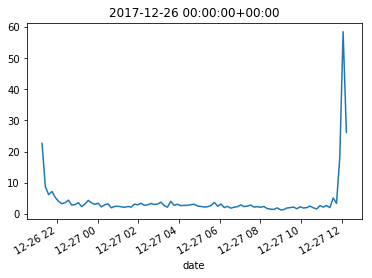

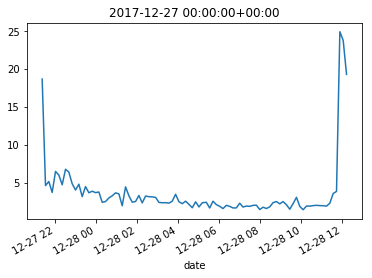

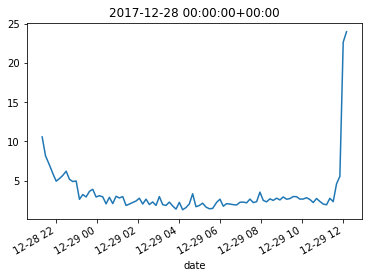

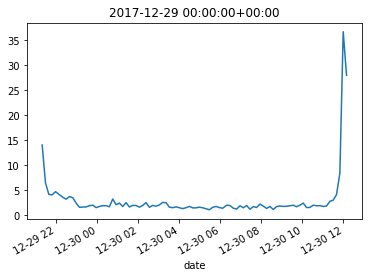

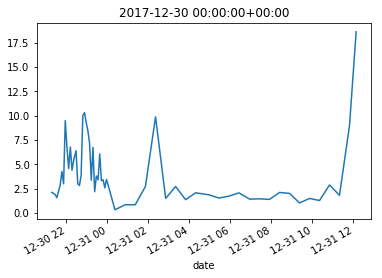

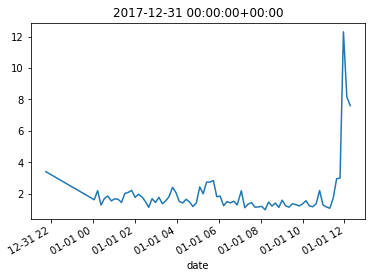

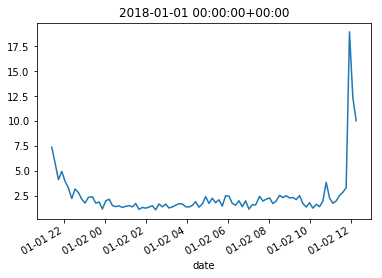

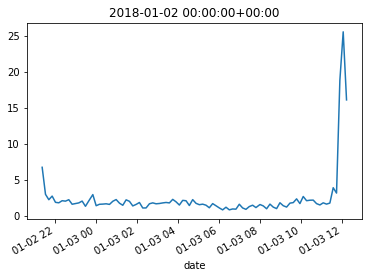

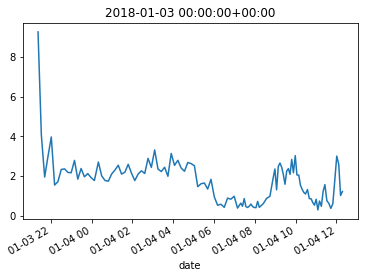

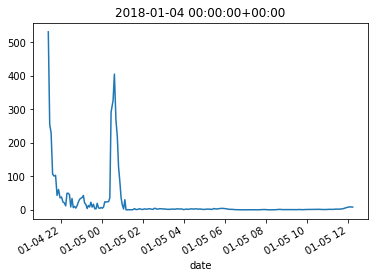

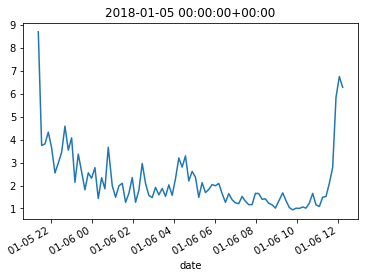

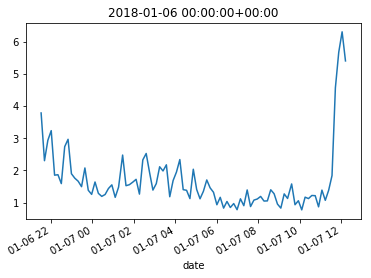

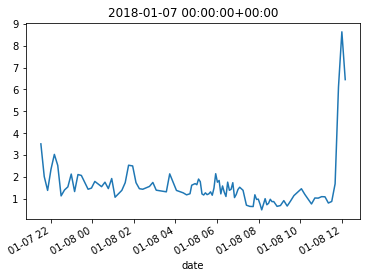

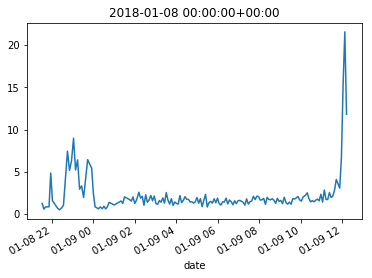

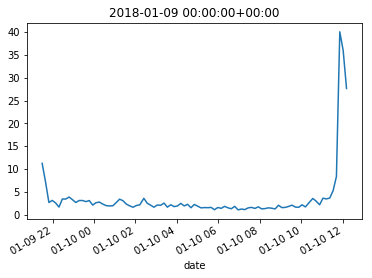

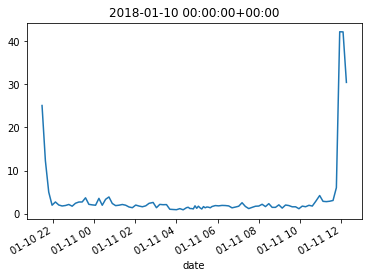

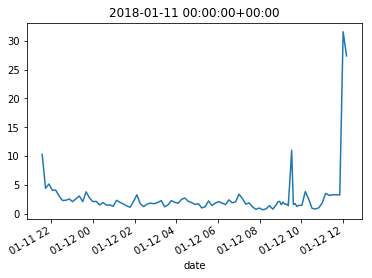

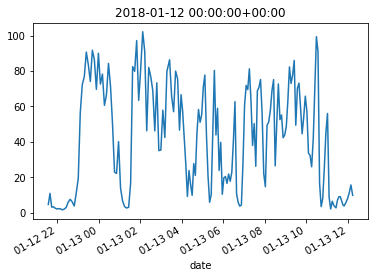

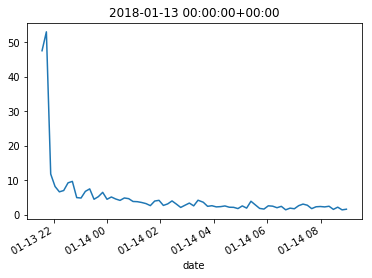

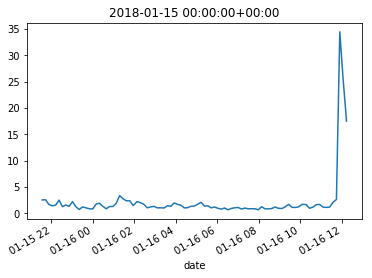

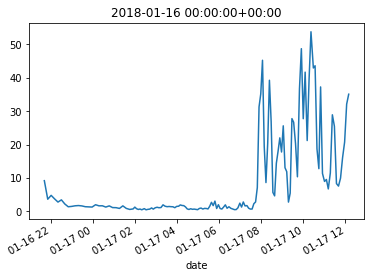

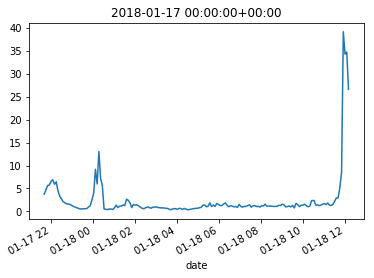

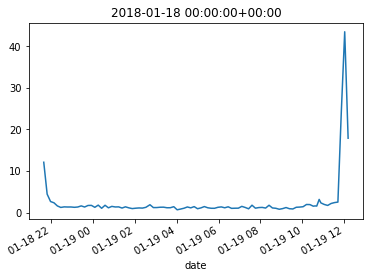

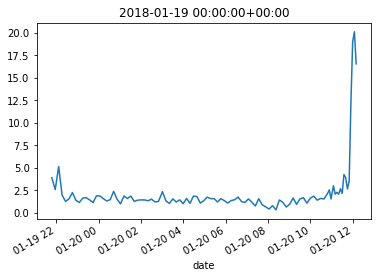

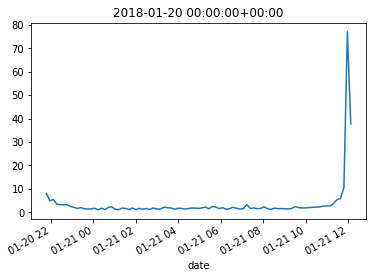

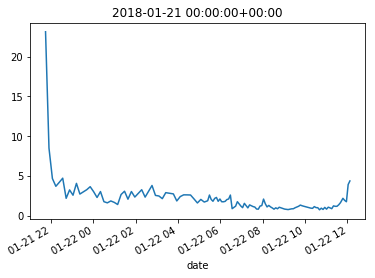

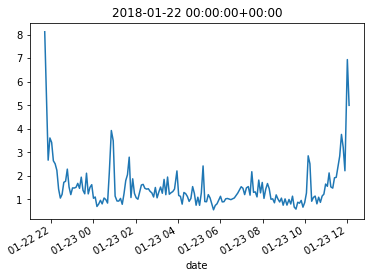

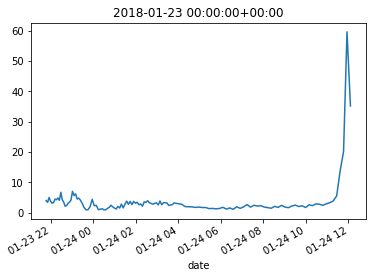

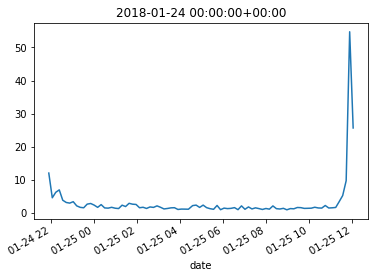

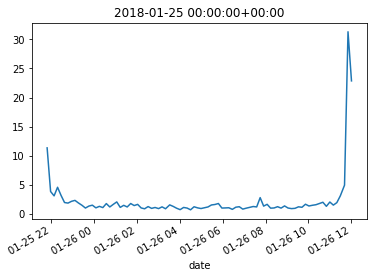

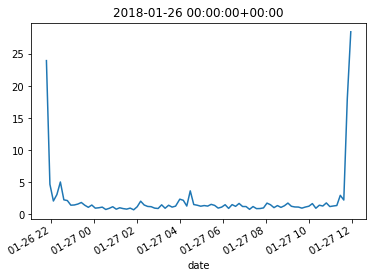

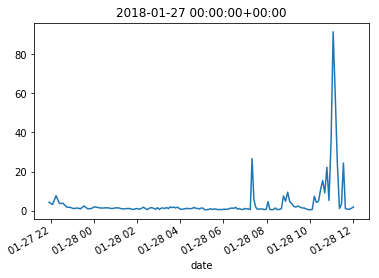

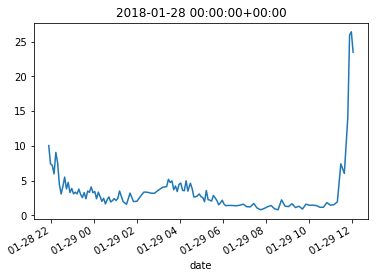

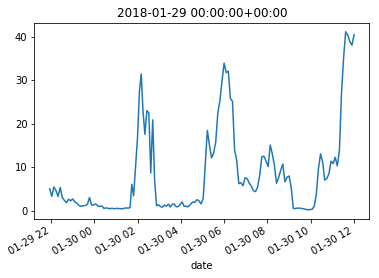

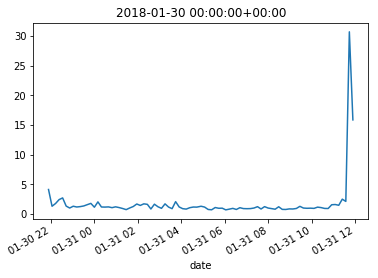

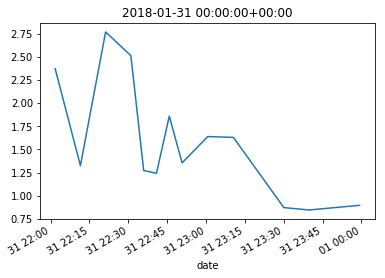

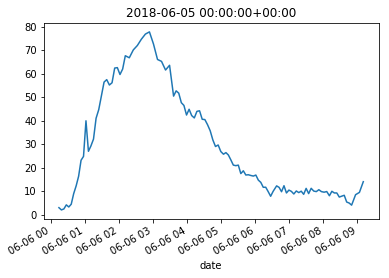

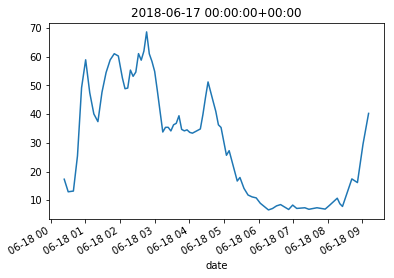

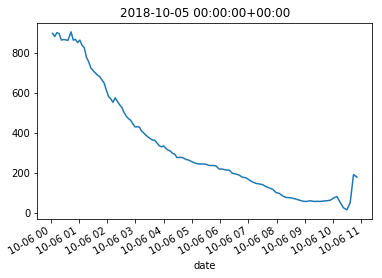

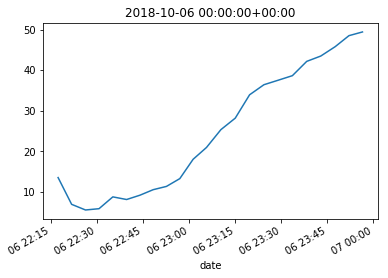

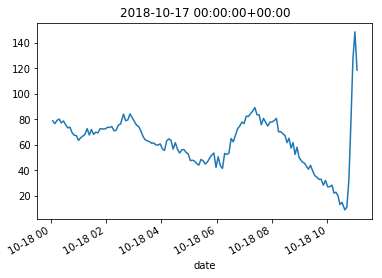

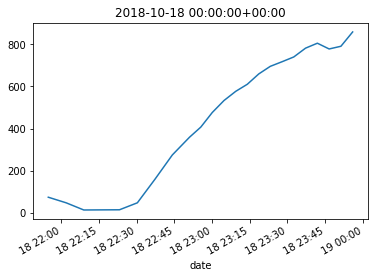

In [24]:
import matplotlib.pyplot as plt

stations = ['KBOX']
years = [2017]

for station in stations:
    
    last_df = None
    df = None
    next_df = None

    lon = NEXRAD_LOCATIONS[station]['lon']
    station_offset = pd.Timedelta(-lon/15, 'h')  # approximate time offset to UTC based on longitude
    noon_offset = pd.Timedelta(12, 'h')
    one_day = pd.Timedelta(1, 'D')
    
    for year in years:

        # Load data frames as needed
        last_df = load_data(root, station, year-1, cache=df)
        df = load_data(root, station, year, cache=next_df)
        next_df = load_data(root, station, year+1)

        # Initialize daily data
        daily_data = init_daily_data(station, year)
        
        for day, row in daily_data.iterrows():
                        
            midnight = day + station_offset             # approx. UTC time of local midnight
            noon = day + noon_offset + station_offset   # approx. UTC time of local noon
                        
            # Day: between midnight and midnight tomorrow and solar angle >= 0
            day_rows = get_rows(df, midnight, midnight + one_day, last_df=last_df, next_df=next_df)
            day_rows = day_rows.loc[day_rows['solar_elevation'] >= 0]
            
            # Night: between noon and noon tomorrow and solar angle < 0
            night_rows = get_rows(df, noon, noon + one_day, last_df=last_df, next_df=next_df)
            night_rows = night_rows.loc[night_rows['solar_elevation'] < 0]

            if not night_rows.empty:
                plt.figure()
                night_rows['total_reflectivity_bio'].plot()
                plt.title(f'{day}')
                plt.show()      
            
            daily_data.loc[day, 'day_reflectivity'] = day_rows['total_reflectivity_bio'].sum()
            daily_data.loc[day, 'night_reflectivity'] = night_rows['total_reflectivity_bio'].sum()
            

In [ ]:
display(day_df['2017-05-01':'2017-06-30'])

In [ ]:
x = None or 23
print(x)

In [ ]:
pd.to_datetime('2011-01-01 00:00:00Z', utc=True)